# Imports

In [98]:
import pandas         as pd
import numpy          as np

import plotly.express as px
import ipywidgets     as widgets

from ipywidgets            import fixed
from matplotlib            import pyplot as plt
from matplotlib            import gridspec
from geopy.geocoders       import Nominatim
from IPython.core.display  import HTML

# Helper Functions

In [99]:
def custom_settings():
    %matplotlib inline
        
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = (20,15)
    plt.rcParams['font.size'] = 10
        
    display( HTML( '<style>.container { width:90% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.options.display.float_format = '{:,.2f}'.format
    pd.set_option( 'display.expand_frame_repr', False)
    
    np.set_printoptions(suppress=True)

In [100]:
def format_numbers():
    pd.set_option('display.float_format', lambda x: '%.2f' % x) 

In [101]:
custom_settings()
format_numbers()

# Data collection

In [102]:
data = pd.read_csv('../data/kc_house_data.csv')

# Data Description

## Data Dimension

In [103]:
print('Number of rows: {}' .format (data.shape[0]))
print('Number of columns: {}' .format (data.shape[1]))

Number of rows: 21613
Number of columns: 21


## Data Types

In [104]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,20141209T000000,538000.00,3,2.25,2570,7242,2.00,0,0,3,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,20150225T000000,180000.00,2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,2487200875,20141209T000000,604000.00,4,3.00,1960,5000,1.00,0,0,5,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,20150218T000000,510000.00,3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503


In [105]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

## Check NA

In [106]:
data.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## Change variables types

In [107]:
# change 'date' type
#print(data[['date','yr_built','yr_renovated']].head(),'\n')
#print(data[['date','yr_built','yr_renovated']].dtypes)
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data['yr_built'] = pd.to_datetime( data['yr_built'], format='%Y')

print('\n\n----- Change -----')
print(data[['date','yr_built','yr_renovated']].dtypes)




----- Change -----
date            datetime64[ns]
yr_built        datetime64[ns]
yr_renovated             int64
dtype: object


## Droping Dupplicates

In [108]:
print(data.shape[0], ' número de linhas')
print(data['id'].unique().shape[0], ' ids únicos')
print(data.shape[0] - data['id'].unique().shape[0], ' número de ids duplicados')

21613  número de linhas
21436  ids únicos
177  número de ids duplicados


In [109]:
# sorting df by date
data = data.sort_values('date', ascending=True)

# del ids that first appear
data = data.drop_duplicates(subset='id', keep='last')

print('nova dimensão:', data.shape)

nova dimensão: (21436, 21)


In [110]:
data.to_csv('../data/dataset.csv', index=False)
data = pd.read_csv('../data/dataset.csv')

# Descriptive Statistics

In [111]:
num_attributes = data.select_dtypes(include=['int64', 'float64'])

media = pd.DataFrame(num_attributes.apply(np.mean))
mediana = pd.DataFrame(num_attributes.apply(np.median))
std = pd.DataFrame(num_attributes.apply(np.std))

max_ = pd.DataFrame(num_attributes.apply(np.max))
min_ = pd.DataFrame(num_attributes.apply(np.min))

desc = pd.concat([max_, min_, media, mediana, std], axis=1).reset_index()
desc.columns = ['attributes', 'max', 'min', 'mean', 'median', 'std']

print(desc)

       attributes           max        min          mean        median           std
0              id 9900000190.00 1000102.00 4580765328.18 3904921185.00 2876522535.73
1           price    7700000.00   75000.00     541649.96     450000.00     367306.36
2        bedrooms         33.00       0.00          3.37          3.00          0.93
3       bathrooms          8.00       0.00          2.12          2.25          0.77
4     sqft_living      13540.00     290.00       2082.70       1920.00        919.13
5        sqft_lot    1651359.00     520.00      15135.64       7614.00      41537.65
6          floors          3.50       1.00          1.50          1.50          0.54
7      waterfront          1.00       0.00          0.01          0.00          0.09
8            view          4.00       0.00          0.24          0.00          0.77
9       condition          5.00       1.00          3.41          3.00          0.65
10          grade         13.00       1.00          7.66         

## Features Creation

In [121]:
geo = pd.read_csv('../data/geolocator.csv') 

if len(geo) != (len(data) - 1):
        
    df_geo = data[['id','lat','long']].copy()
    df_geo['road'] = 'NA'
    df_geo['house_number'] = 'NA'
    df_geo['neighbourhood'] = 'NA'
    df_geo['city'] = 'NA'
    df_geo['country'] = 'NA'
    df_geo['state'] = 'NA'
    df_geo['osm'] = 'NA'
    
    print('INICIO DA COLETA')
    s = 0
    e = 2000
    
    print('NÚMERO DE LINHAS', len(df_geo))
    
    while s < len(df_geo):
        
        geolocator = Nominatim( user_agent='geoapiExercises')
        
        try:
            for i in range(s,e):

                query = str(df_geo.loc[i, 'lat']) + ',' + str(df_geo.loc[i,'long'])

                response = geolocator.reverse(query) #API Request

                #Populate data
                if 'house_number' in response.raw['address']:
                    df_geo.loc[i, 'house_number'] = response.raw['address']['house_number']

                if 'road' in response.raw['address']:
                    df_geo.loc[i, 'road'] = response.raw['address']['road']

                if 'neighbourhood' in response.raw['address']:
                    df_geo.loc[i, 'neighbourhood'] = response.raw['address']['neighbourhood']

                if 'city' in response.raw['address']:
                    df_geo.loc[i, 'city'] = response.raw['address']['city']

                if 'country' in response.raw['address']:
                    df_geo.loc[i, 'country'] = response.raw['address']['country']

                if 'state' in response.raw['address']:
                    df_geo.loc[i, 'state'] = response.raw['address']['state']

                if 'osm_type' in response.raw:
                    df_geo.loc[i, 'osm'] = response.raw['osm_type']

            print('UPDATE LINES {} | {}'.format(s,e))

            aux = df_geo
            aux.to_csv('../data/geolocator.csv', index=False, header=False)
            
            s = e + 1
            e = e + 2000
            if e >= len(df_geo):
                e = len(df_geo)
            else:
                e = e
        
        except:
            print('ERRO NA REQUISIÇÃO')
        
    print('FIM DA COLETA')
    
    cols_name = ['id','lat','long','road','house_number','neighbourhood','city','country','state','osm']
    
    df_geo = pd.read_csv('../data/geolocator.csv',names=cols_name)
    df_geo = df_geo.drop(columns=['lat', 'long'])
    
    data = pd.merge(data, df_geo, how='left', on='id')

else:
    print('DATASET ATUALIZADO')
    
    cols_name = ['id','lat','long','road','house_number','neighbourhood','city','country','state','osm']
    df_geo = pd.read_csv('../data/geolocator.csv',names=cols_name)
    df_geo = df_geo.drop(columns=['lat', 'long'])
    
    data = pd.merge(data, df_geo, how='left', on='id')    

DATASET ATUALIZADO


In [123]:
data['dormitory_type'] = 'type'
data.loc[data['bedrooms'] <= 1, 'dormitory_type'] = 'studio'
data.loc[data['bedrooms'] == 2, 'dormitory_type'] = 'apartament'
data.loc[data['bedrooms'] >= 3, 'dormitory_type'] = 'house'

In [124]:
# media de preço por zipcode

# create media
temp = data[['price','zipcode']].groupby('zipcode').median().reset_index().rename(columns={'price': 'median_price'})
temp.head()

# merge on dataset
data = pd.merge(data, temp, on='zipcode', how='left')
data[['id', 'price', 'zipcode', 'median_price']].sample(5)


,id,price,zipcode,median_price
5122,6386200100,430000.00,98034,446000.00
1332,5701700011,1050000.00,98052,615000.00
20638,1771000960,380000.00,98077,652475.00
18968,6072760390,547500.00,98006,760184.50
13578,8911000030,355000.00,98133,375000.00


In [125]:
# buying decision
# as variaveis levadas em conta são média de preço da região e a condição
data['decision'] = data[['price', 'median_price', 'condition']].apply(lambda x: 1 if ((x['price'] <= x['median_price']) & (x['condition']>=3)) else 0, axis=1) 
data[['id', 'zipcode', 'price', 'median_price', 'condition', 'decision']].sample(5)

,id,zipcode,price,median_price,condition,decision
10357,3797002575,98103,605000.00,550000.00,4,0
3467,7518505070,98117,402000.00,545000.00,5,1
18661,2126059048,98034,294000.00,446000.00,3,1
21229,1332200100,98031,393000.00,289029.50,3,0
19116,3438502066,98106,229000.00,315000.00,3,1


In [126]:
# selling price suggestion
data['selling_suggestion'] = data[['price', 'median_price', 'condition']].apply(lambda x: x['price']*1.25
                                                                    if ((x['price'] <= x['median_price']) & (x['condition']>=3)) else 0, axis=1)

data[['id', 'zipcode', 'price', 'median_price', 'condition', 'decision', 'selling_suggestion']].sample(5)


,id,zipcode,price,median_price,condition,decision,selling_suggestion
18017,6388910040,98056,537100.00,380000.00,3,0,0.00
18000,6705600020,98075,919990.00,739999.50,3,0,0.00
17425,2560800165,98198,180500.00,266750.00,3,1,225625.00
14451,4019300680,98155,449000.00,377225.00,4,0,0.00
19220,7852180430,98065,450000.00,500000.00,3,1,562500.00


In [127]:
# expected profit
data['expected_profit'] = data[['price', 'selling_suggestion']].apply(lambda x: 0 if x['selling_suggestion']==0
                                                                                        else (x['selling_suggestion'] - x['price']), axis=1) 

data[['id', 'zipcode', 'price', 'median_price', 'condition', 'decision', 'selling_suggestion', 'expected_profit']].sample(5)

,id,zipcode,price,median_price,condition,decision,selling_suggestion,expected_profit
5240,1150000400,98029,700000.00,574500.00,4,0,0.00,0.00
8017,11501330,98052,795000.00,615000.00,3,0,0.00,0.00
2952,7327500200,98045,455000.00,399500.00,3,0,0.00,0.00
2358,5561301220,98027,589900.00,571000.00,3,0,0.00,0.00
20863,2909300240,98074,725000.00,645000.00,3,0,0.00,0.00


In [128]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
# seasons of the year
def date_season(date):
    
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'fall': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['fall']:
        return 'fall'
    else:
        return 'winter'

data['season'] = data['date'].map(date_season)
data[['date','season']].head()

,date,season
0,2014-05-02,spring
1,2014-05-02,spring
2,2014-05-02,spring
3,2014-05-02,spring
4,2014-05-02,spring


In [129]:
# median price per season and zipcode

# grouping by zipcode and median price by season
aux = data[['price','zipcode','season']].groupby(['zipcode', 'season']).median().reset_index()

aux1 = aux.pivot(index='zipcode', columns='season', values='price').reset_index()
aux1 = aux1.rename(columns={'fall':'med_fall', 'spring':'med_spring', 'summer':'med_summer', 'winter':'med_winter'})

# merge
data = pd.merge(data, aux1, on='zipcode', how='left')

# sample
data[['id', 'price', 'zipcode', 'median_price', 'med_fall', 'med_spring', 'med_summer', 'med_winter']].sample(5)

,id,price,zipcode,median_price,med_fall,med_spring,med_summer,med_winter
12291,7011200160,595000.00,98119,744975.00,762500.00,819500.00,680707.50,637475.00
5579,4019300906,685000.00,98155,377225.00,360000.00,382000.00,364500.00,403000.00
14416,742000060,1200000.00,98052,615000.00,600000.00,625000.00,620000.00,602000.00
7168,1214700090,280000.00,98148,279000.00,249500.00,273100.00,280000.00,285000.00
19998,5452800495,899100.00,98040,993750.00,1070000.00,1081000.00,940000.00,1049000.00


In [130]:
# Best season to sell

data['season_sell'] = ''

# defining best season to sell accorgding to avg price for each season
for i in range (len(data)):
    cols = ['med_fall', 'med_spring', 'med_summer', 'med_winter']
    
    if data.loc[i, 'decision']!=0:
    
        if data.loc[i, cols[0]] >= data.loc[i,'price']:
            data.loc[i, 'season_sell'] = data.loc[i, 'season_sell'] + 'autumn '
        if data.loc[i, cols[1]] >= data.loc[i,'price']:
            data.loc[i, 'season_sell'] = data.loc[i, 'season_sell'] + 'spring '
        if data.loc[i, cols[2]] >= data.loc[i,'price']:
            data.loc[i, 'season_sell'] = data.loc[i, 'season_sell'] + 'summer '
        if data.loc[i, cols[3]] >= data.loc[i,'price']:
            data.loc[i, 'season_sell'] = data.loc[i, 'season_sell'] + 'winter '

data[['id', 'price', 'zipcode', 'median_price', 'med_fall', 'med_spring', 'med_summer', 'med_winter', 'decision', 'season_sell']].head()

,id,price,zipcode,median_price,med_fall,med_spring,med_summer,med_winter,decision,season_sell
0,5561000190,437500.00,98027,571000.00,545000.00,574950.00,575000.00,538100.00,1,autumn spring summer winter
1,472000620,790000.00,98117,545000.00,535000.00,544000.00,545000.00,554500.00,0,
2,1024069009,675000.00,98029,574500.00,575000.00,592500.00,561000.00,555000.00,0,
3,7853361370,555000.00,98065,500000.00,452250.00,516000.00,485000.00,520000.00,0,
4,5056500260,440000.00,98006,760184.50,760369.00,760000.00,758000.00,791270.50,1,autumn spring summer winter


# Data exploration

## Hypothesis creation

### 1- Propriedades com vista para o mar são 40% mais caras.
**Falso:** Propriedades com vista para água tem um valor 211.76% mais caras.

In [133]:
aux = data[['waterfront', 'price']].groupby('waterfront').mean().reset_index()

not_waterfront = aux.iloc[0,1]
yes_waterfront = aux.iloc[1,1]

percent = abs( ((yes_waterfront - not_waterfront) / not_waterfront)*100 )
print('\nPropriedades com vista para água são', '{:,.2f}'.format(percent),'% mais caras')


Propriedades com vista para água são 211.76 % mais caras


### 2- As propriedades com porão têm um estado de conservação melhor.
**Verdade:** Propriedades com porões tem qualidade ligeiramente superior.

<BarContainer object of 5 artists>

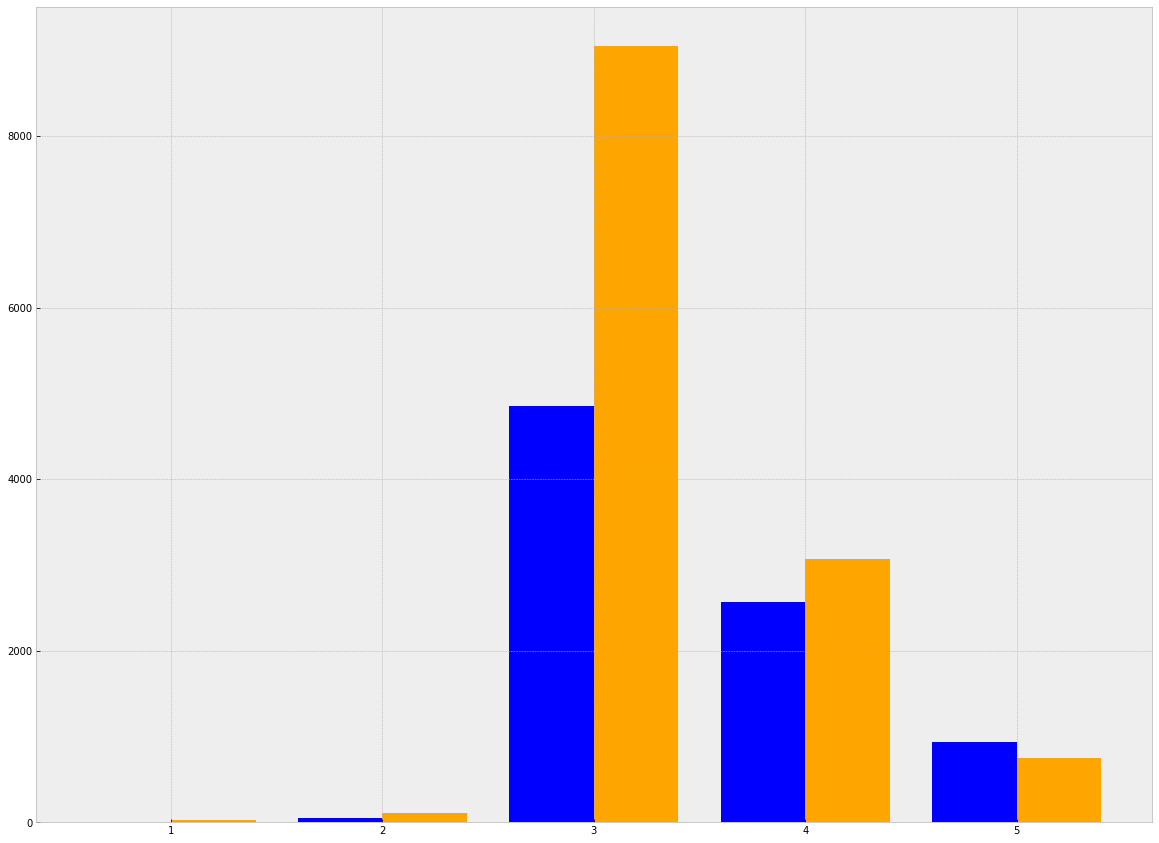

In [177]:
# Propriedades com porão
aux1 = data[data['sqft_basement']!=0][['id','condition','sqft_basement']].copy()
y_porao = aux1[['id','condition']].groupby('condition').count().reset_index()

# Propriedades sem porão
aux2 = data[data['sqft_basement']==0][['id','condition','sqft_basement']].copy()
n_porao = aux2[['id','condition']].groupby('condition').count().reset_index()

#width = 0.40
plt.bar(y_porao['condition']-0.2, y_porao['id'], width, color='blue', label='Possui porão')
plt.bar(n_porao['condition']+0.2, n_porao['id'], width, color='orange', label='Não possui porão')

In [135]:
# nota média ponderada
avg_yporao = np.average(np.array(y_porao['condition']), weights=np.array(y_porao['id']))
print('Nota média ponderada para propriedades com porão: {:,.2f}'.format(avg_yporao))

avg_nporao = np.average(np.array(n_porao['condition']), weights=np.array(n_porao['id']))
print('Nota média ponderada para propriedades sem porão: {:,.2f}'.format(avg_nporao))

print('\nPequena diferença na qualidade para propriedades com porão.')

Nota média ponderada para propriedades com porão: 3.52
Nota média ponderada para propriedades sem porão: 3.34

Pequena diferença na qualidade para propriedades com porão.


### 3- Imóveis com porão têm maior espaço interior.
**Verdade:** As propriedades com porão têm, em média um espaço 19.83% maior.

In [136]:
y_porao = data[data['sqft_basement']!=0][['sqft_living']].mean()[0]
n_porao = data[data['sqft_basement']==0][['sqft_living']].mean()[0]

print('Média de espaço interior de imóveis com porão: {:,.2f}'.format(y_porao))
print('Média de espaço interior de imóveis sem porão: {:,.2f}'.format(n_porao))

percent = abs( ((y_porao - n_porao) / n_porao)*100 )
print('\nImóveis com porão tem em média um espaço ', '{:,.2f}'.format(percent),'% maior.')

Média de espaço interior de imóveis com porão: 2,315.30
Média de espaço interior de imóveis sem porão: 1,932.21

Imóveis com porão tem em média um espaço  19.83 % maior.


### 4- Imóveis com porão são 15% mais caros.
**Falso:** Imóveis com porão são em média 27,84% mais caros.

In [137]:
y_porao = data[data['sqft_basement']!=0][['price']].mean()[0]
print('Average price of properties with basement: {:,.2f}'.format(y_porao))

n_porao = data[data['sqft_basement']==0][['price']].mean()[0]
print('Average price of properties without basement: {:,.2f}'.format(n_porao))

percent = abs( ((y_porao - n_porao) / n_porao)*100 )
print('Properties with basement are', '{:,.2f}'.format(percent),'% more expensive.')

Average price of properties with basement: 623,967.32
Average price of properties without basement: 488,388.76
Properties with basement are 27.76 % more expensive.


### 5- Propriedades construídas com porões diminuíram ao longo dos anos.
**Verdade:** Propriedades construídas com subsolos começaram a ter uma diminuição acentuada no fim dos anos 70.

In [138]:
data['yr_built'] = pd.to_datetime(data['yr_built']).dt.strftime('%Y')

total = data[['id', 'yr_built']].groupby('yr_built').count().reset_index()
total.head()

,yr_built,id
0,1900,86
1,1901,29
2,1902,27
3,1903,45
4,1904,44


In [139]:
y_porao = data[data['sqft_basement']!=0][['sqft_basement','yr_built']].groupby('yr_built').count().reset_index()
y_porao.head()

,yr_built,sqft_basement
0,1900,29
1,1901,11
2,1902,5
3,1903,10
4,1904,20


In [140]:
compara = pd.merge(total, y_porao, on='yr_built', how='left').rename(columns={'id': 'properties', 'sqft_basement': 'y_porao'})
compara['n_porao'] = compara['properties'] - compara['y_porao']
compara.head()

,yr_built,properties,y_porao,n_porao
0,1900,86,29,57
1,1901,29,11,18
2,1902,27,5,22
3,1903,45,10,35
4,1904,44,20,24


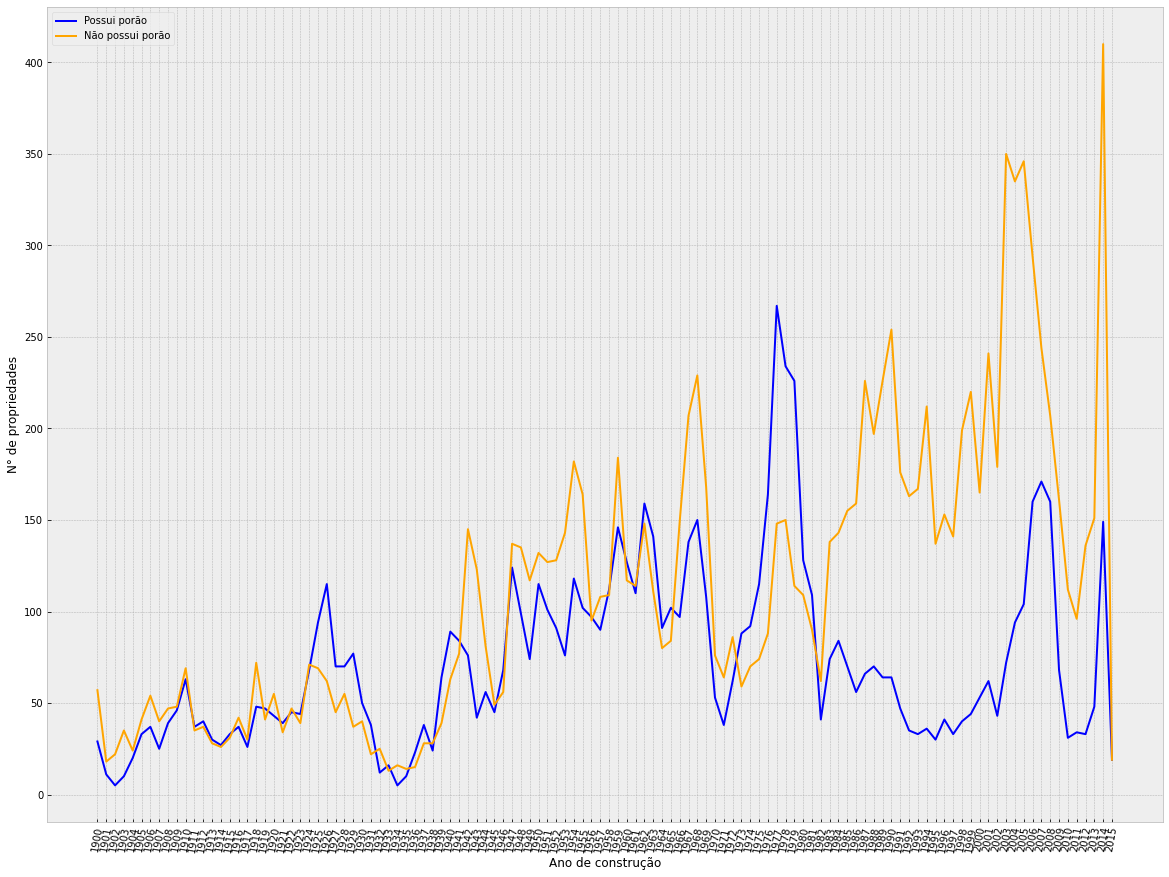

In [141]:
plt.xticks( rotation=80)
plt.plot(compara['yr_built'], compara['y_porao'], color='blue', label='Possui porão')
plt.plot(compara['yr_built'], compara['n_porao'], color='orange', label='Não possui porão')
plt.xlabel('Ano de construção')
plt.ylabel('N° de propriedades')
plt.legend()
plt.show()

### 6 - Imóveis com 2 banheiros são 20% mais caros do que imóveis com até 1 banheiro.
**Falso:** Imóveis com 2 banheiros são 37,99% mais caros do que aqueles com até 1 banheiro.

In [142]:
aux = data[['id', 'bathrooms', 'price']].copy()

aux1 = (aux.groupby('bathrooms').agg(properties = ('id', 'count'),
                                avg_price  = ('price', 'mean'))).reset_index()

aux2 = aux1[aux1['bathrooms']<=1]
aux2_mean = aux2['avg_price'].mean()
print('Preço médio de imóveis com até 1 banheiro: {:,.2f}'.format(aux2_mean))

aux3 = aux1[(aux1['bathrooms']==2)]
aux3_mean = aux3['avg_price'].mean()
print('Preço médio de imóveis com 2 banheiros: {:,.2f}'.format(aux3_mean))

percent = abs( ((aux3_mean - aux2_mean) / aux2_mean)*100 )
print('Imóveis com 2 banheiros são', '{:,.2f}'.format(percent),'% mais caros.')

Preço médio de imóveis com até 1 banheiro: 332,861.36
Preço médio de imóveis com 2 banheiros: 459,307.01
Imóveis com 2 banheiros são 37.99 % mais caros.


### 7- Propriedades com 3 quartos são 30% mais caras do que aquelas com 2 quartos.
** Falso: ** Imóveis com 3 quartos são 25,24% mais caros do que aqueles com 2 quartos.

In [143]:
aux = data[['id', 'bedrooms', 'price']].copy()

aux1 = (aux.groupby('bedrooms').agg(properties = ('id', 'count'),
                               avg_price  = ('price', 'mean'))).reset_index()

aux2 = aux1.iloc[1,2]
aux3 = aux1.iloc[2,2]

print('Preço médio de imóveis com 2 quartos: {:,.2f}'.format(aux2))
print('Preço médio de imóveis com 3 quartos: {:,.2f}'.format(aux3))

percentage = abs( ((aux3 - aux2) / aux2)*100 )
print('Properties with 3 bedrooms are ', '{:,.2f}'.format(percentage),'% more expensive than those which have 2 bedrooms.')

Preço médio de imóveis com 2 quartos: 321,180.07
Preço médio de imóveis com 3 quartos: 402,230.37
Properties with 3 bedrooms are  25.24 % more expensive than those which have 2 bedrooms.


### 8- Imóveis reformados são 30% mais caros.
**Falso:** Imóveis reformados são 17,80% mais caros do que os não reformados.

In [144]:
# imóveis reformados são 30% mais caros

aux = data[['id', 'yr_renovated', 'price']].copy()

aux1 = (aux.groupby('yr_renovated').agg(properties = ('id', 'count'),
                                    avg_price  = ('price', 'mean'))).reset_index()

aux2 = aux1[aux1['yr_renovated'] > 0 ]
aux2_mean = aux2['avg_price'].mean()
print('Média de preço de imóveis reformados: {:,.2f}'.format(aux2_mean))

aux3 = aux1[aux1['yr_renovated'] == 0 ]
aux3_mean = aux3['avg_price'].mean()
print('Média de preço de imóveis sem reformas: {:,.2f}'.format(aux3_mean))

percentage = abs( ((aux3_mean - aux2_mean) / aux2_mean)*100 )
print('Imóveis reformados são ', '{:,.2f}'.format(percentage),'% mais caros.')

Média de preço de imóveis reformados: 647,088.46
Média de preço de imóveis sem reformas: 531,875.73
Imóveis reformados são  17.80 % mais caros.


### 9- Imóveis reformados tem uma avaliação 20% maior
**Falso:** Imóveis reformados tem uma avaliação 4.28% maior que imóveis não reformados.

In [179]:
aux = data[['id', 'yr_renovated', 'grade']].copy()

aux1 = (aux.groupby('yr_renovated').agg(properties = ('id', 'count'),
                                    avg_grade  = ('grade', 'mean'))).reset_index()

aux2 = aux1[aux1['yr_renovated'] > 0 ]
aux2_mean = aux2['avg_grade'].mean()
print('Média de preço de imóveis reformados: {:,.2f}'.format(aux2_mean))

aux3 = aux1[aux1['yr_renovated'] == 0 ]
aux3_mean = aux3['avg_grade'].mean()
print('Média de preço de imóveis sem reformas: {:,.2f}'.format(aux3_mean))

percentage = abs( ((aux3_mean - aux2_mean) / aux2_mean)*100 )
print('Imóveis reformados tem uma avalição ', '{:,.2f}'.format(percentage),'% maior.')

Média de preço de imóveis reformados: 7.34
Média de preço de imóveis sem reformas: 7.66
Imóveis reformados tem uma avalição  4.28 % maior.


### 10- Studios são 35% mais baratos que apartamentos
** Falso: ** Studios são 25.24 % mais baratos do que apartamentos.

In [146]:
aux = data[['id', 'dormitory_type', 'price']].copy()

aux1 = (aux.groupby('dormitory_type').agg(properties = ('id', 'count'),
                                     avg_price  = ('price', 'mean'))).reset_index()

f1 = aux1[aux1['dormitory_type'] == 'studio']
f1_mean = f1['avg_price'].mean()
print('Preço médio de studios: {:,.2f}'.format(f1_mean))

f2= aux1[aux1['dormitory_type']== 'apartament']
f2_mean = f2['avg_price'].mean()
print('Preço médio de apartamentos: {:,.2f}'.format(f2_mean))

percentage = abs( ((f2_mean - f1_mean) / f1_mean)*100 )
print('Studios são {:,.2f}'.format(percentage),'% mais baratos do que apartamentos.')

Preço médio de studios: 326,726.98
Preço médio de apartamentos: 402,230.37
Studios são 23.11 % mais baratos do que apartamentos.


### 11- A maioria das propriedades (+ 50%) ficou disponível durante o verão / primavera.
** Verdadeiro: ** Aproximandamente 60% das propriedades ficaram disponíveis durante o verão / primavera.

In [169]:
season = data[['season', 'id']].copy()

season['SS_FW'] = season.apply(lambda x: 'SS' if x['season']=='summer' 
                          else 'SS' if x['season']=='spring' 
                          else 'FW', axis=1)


disp = season[['SS_FW', 'id']].groupby('SS_FW').count().sort_values('id', ascending=False).reset_index()
disp['%'] = disp['id']/disp['id'].sum()*100
disp.head()

,SS_FW,id,%
0,SS,12847,59.93
1,FW,8589,40.07


### 12- Imóveis disponíveis durante o verão / primavera são 20% mais caros.
** Falso: ** Os imóveis disponíveis no verão / primavera são 4,5% mais caros.

In [148]:
aux = data[['id', 'season', 'price']].copy()

aux['SS_AW'] = aux.apply(lambda x: 'SS' if x['season']=='summer' 
                          else 'SS' if x['season']=='spring' 
                          else 'AW', axis=1)

valor = (aux.groupby('SS_AW').agg(properties   = ('id', 'count'),
                            price_min    = ('price', 'min'),
                            price_max    = ('price', 'max'),
                            price_median = ('price', 'median'),
                            price_mean   = ('price', 'mean')) ).sort_values('price_mean', ascending=False).reset_index()

SS_mean = valor.iloc[0,5]
FW_mean = valor.iloc[1,5]

percent = abs( ((SS_mean - FW_mean) / FW_mean)*100 )
print('Imóveis disponíveis durante a primavera ou verão são ', '{:,.2f}'.format(percent),'% mais caros.')

valor.head()

Imóveis disponíveis durante a primavera ou verão são  4.50 % mais caros.


,SS_AW,properties,price_min,price_max,price_median,price_mean
0,SS,12847,78000.00,7062500.00,463000.00,551150.93
1,AW,8589,75000.00,7700000.00,437500.00,527438.88


### 13- A maioria das propriedades (+ 50%) que devem ser compradas são apartamentos.
** Falso: ** Apartamentos representam 12.76% dos imóveis qualificados para compra.

In [161]:
# distribuição de casas disponiveis para venda

auxb = data[['id', 'dormitory_type']].copy()
auxb = auxb[['dormitory_type', 'id']].groupby('dormitory_type').count().sort_values('id', ascending=False).reset_index()
auxb['%'] = (auxb['id']/auxb['id'].sum()) * 100

auxb.head()

,dormitory_type,id,%
0,house,18493,86.27
1,apartament,2736,12.76
2,studio,207,0.97


<BarContainer object of 3 artists>

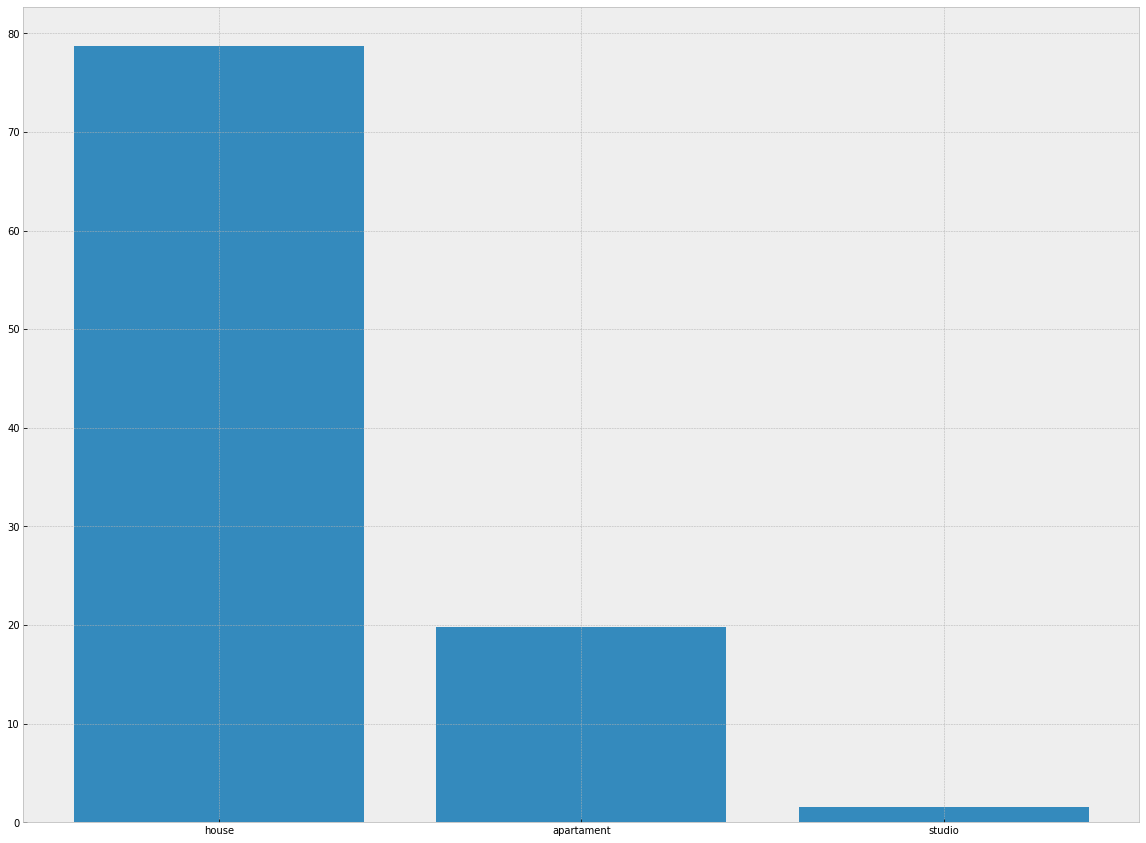

In [163]:
aux = data[data['decision']!=0][['id', 'dormitory_type', 'decision']].copy()

aux1 = aux[['dormitory_type', 'decision']].groupby('dormitory_type').count().sort_values('decision', ascending=False).reset_index()
aux1['%'] = (aux1['decision']/aux1['decision'].sum()) * 100

aux1.head()
plt.bar(aux1['dormitory_type'], aux1['%'])

### 14- Os imóveis tem maior espaço interior ao longo dos anos de construção.
** Verdadeiro: ** As propriedades têm maior espaço interior ao longo dos anos de construção.

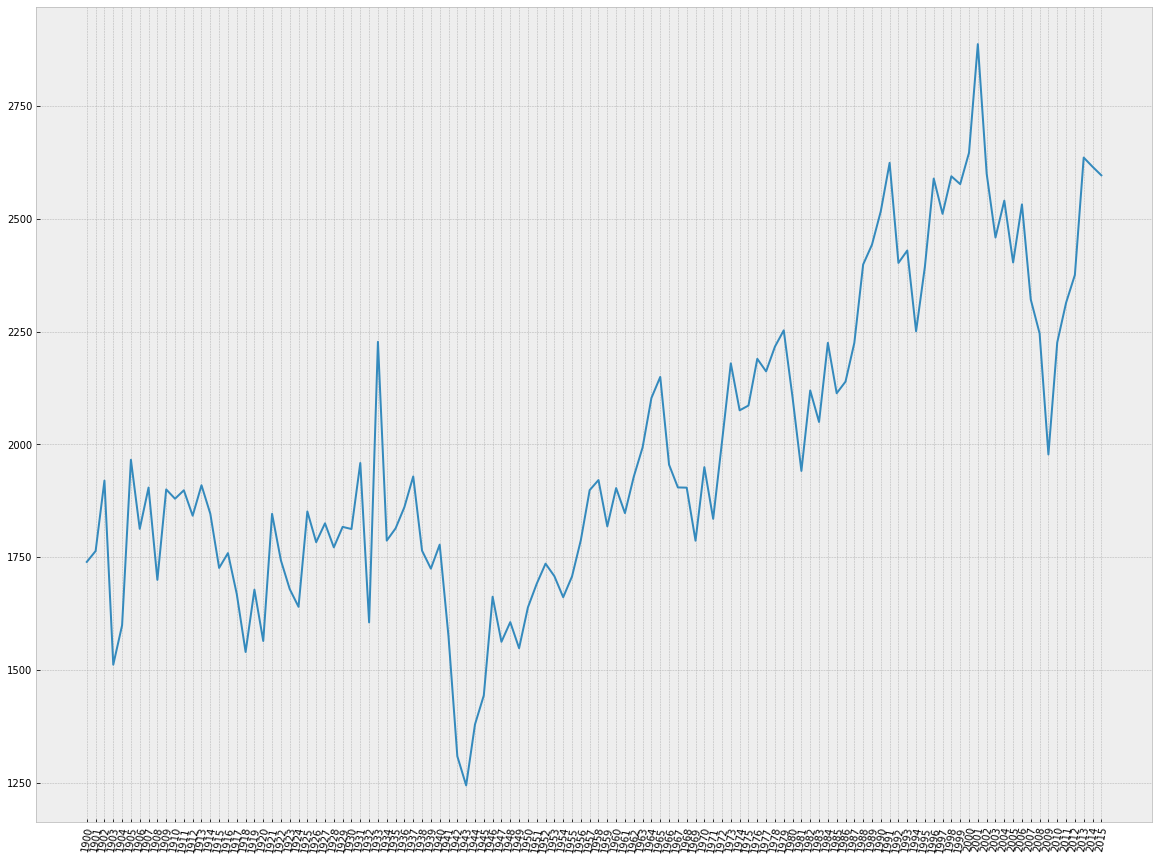

In [150]:
aux = data[['sqft_living', 'yr_built']].copy()

aux1 = aux.groupby('yr_built').mean().reset_index()

plt.xticks( rotation=80)
plt.plot(aux1['yr_built'], aux1['sqft_living'])
plt.show()

### 15- As propriedades selecionadas para compra com vista para a água correspondem 25% do lucro esperado.
** Falso: ** As propriedades selecionadas para compra com vistá para água representam menos de 1% do lucro esperado.

In [183]:
# casas qualificadas para compra com vista para a água

aux = data[data['decision']!=0][['id', 'waterfront']].copy()
aux = aux[['waterfront', 'id']].groupby('waterfront').count().sort_values('id', ascending=False).reset_index()

aux.head()

,waterfront,id
0,0,10632
1,1,10


In [184]:
aux = data[data['expected_profit']!=0][['id', 'waterfront', 'expected_profit']].copy()

aux1 = ( aux[['waterfront', 'expected_profit']].groupby('waterfront').agg(profit_min    = ('expected_profit', 'min'),
                                                                          profit_max    = ('expected_profit', 'max'),
                                                                          profit_median = ('expected_profit', 'median'),
                                                                          profit_mean   = ('expected_profit', 'mean'),
                                                                          profit_sum    = ('expected_profit', 'sum'),) ).reset_index()

aux1['%'] = (aux1['profit_sum']/aux1['profit_sum'].sum()) * 100

aux1.head()

,waterfront,profit_min,profit_max,profit_median,profit_mean,profit_sum,%
0,0,18750.00,476250.00,90000.00,97312.66,1034628182.75,99.91
1,1,71250.00,116250.00,93737.50,92112.30,921123.00,0.09
